In [1]:
import time
import win32gui
import numpy as np

import mss
import mss.tools
from PIL import Image, ImageOps

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from cloningCNN import CloningCNN, ResNet

from torch.distributions import Categorical

from pynput.keyboard import Key, Controller
import matplotlib.pyplot as plt

# Define RL environment for the game window

In [2]:
class GameEnv:
    def __init__(self, windowName, inputInterval, usingResNet=False):
        self.gameBbox = self.getWindowBbox(windowName)
        self.capper = mss.mss()
        self.capNum = 0
        self.downsamplingMethod = Image.NEAREST
        self.usingResNet = usingResNet
        
        self.captureWindow = None
        self.prevGoldPixels = None
        self.prevLvlPixels = None
        
        self.keyboard = Controller()
        self.keyCodes = {0:Key.up, 1:Key.right, 2:Key.down, 3:Key.left}
        self.inputInterval = inputInterval
        
    def getWindowBbox(self, windowName):
        gameWindow = win32gui.FindWindow(None, windowName)
        if gameWindow == 0:
            print("Could not find game window for \"" + windowName + "\". Exiting.")
            exit()
        
        bbox = list(win32gui.GetWindowRect(gameWindow))
        # fix idiosyncrasies of win32gui window rect acquisition
        bbox[0] += 8
        bbox[1] += 31
        width = bbox[2]-bbox[0]
        height = bbox[3]-bbox[1]
        # return a 'monitor' object in the format that the mss library wants
        return {'top': bbox[1], 'left': bbox[0], 'width': width-8, 'height': height-8}
    
    def quickRestart(self):
        for key in [Key.esc, Key.up, Key.up, Key.up, Key.right]:
            self.keyboard.press(key)
            self.keyboard.release(key)
            time.sleep(0.1)
        time.sleep(1)
    
    def reset(self):
        self.quickRestart()
        initScreen, initGoldPixels, initLvlPixels, heartPixels = self.getScreenInfo()
        self.prevGoldPixels = initGoldPixels
        self.prevLvlPixels = initLvlPixels
        self.prevHeartPixels = heartPixels
        self.captureWindow = [initScreen for _ in range(4)]
        
        return self.captureWindow
    
    def getScreenInfo(self):
        # capture screen and downscale to 180x180
        self.capNum += 1
        screenCap = self.capper.grab(self.gameBbox)
        img = Image.frombytes('RGB', screenCap.size, screenCap.bgra, 'raw', 'BGRX')
        heartPixels = []
        if self.usingResNet:
            final = img.resize((224,224), self.downsamplingMethod)
            # check for reward indicators
            goldPixels = np.array(final.crop((201,7,218,15))) == 255 # resnet version
            lvlPixels = np.array(final.crop((219,219,224,224))) == 255 # resnet version
            for pixelCoord in [153,158,170,175]: # resnet version
                heartPixels.append(np.array(final.crop((pixelCoord,10,pixelCoord+1,11))).sum())
        else:
            padded = ImageOps.expand(img, (30,38,26,18))
            resized = padded.resize((360,360), self.downsamplingMethod)
            final = resized.resize((180,180), self.downsamplingMethod)
            # check for reward indicators
            goldPixels = np.array(final.crop((158,11,170,17))) == 255 # white pixels of gold meter in top right
            lvlPixels = np.array(final.crop((170,170,180,180))) == 255
            for pixelCoord in [121,125,134,138]:
                heartPixels.append(np.array(final.crop((pixelCoord,12,pixelCoord+1,13))).sum())

        return (final, goldPixels.astype(int), lvlPixels.astype(int), heartPixels)
    
    def step(self, action):
        done = False
        reward = 0
        
        # carry out action
        keyPress = self.keyCodes[action]
        self.keyboard.press(keyPress)
        self.keyboard.release(keyPress)
        
        # wait, then get new game capture
        time.sleep(self.inputInterval)
        screen, goldPixels, lvlPixels, heartPixels = self.getScreenInfo()
        
        # check if got reward
        if np.sum(np.abs(goldPixels - self.prevGoldPixels)) != 0: # gold value changed
            reward += 10
        if np.sum(np.abs(lvlPixels - self.prevLvlPixels)) != 0: # beat level 1
            reward += 100
            done = True
            
        # check for damage or dead
        for heartIndex, heartPixel in enumerate(heartPixels):
            if self.prevHeartPixels[heartIndex] != 115 and heartPixel == 115:
                reward -= 10
#                 print ("lost heart {}. penalty applied.".format(heartIndex))
        if heartPixels[0] == 115:
            done = True
            
        # update state variables
        self.prevGoldPixels = goldPixels
        self.prevLvlPixels = lvlPixels
        self.prevHeartPixels = heartPixels
        self.captureWindow.pop()
        self.captureWindow.insert(0, screen)
        
        return (self.captureWindow, reward, done)

# Define Agent with CNN

In [3]:
class CloningAgent:
    def __init__(self, model, normTransform, gamma=0.99):
        if torch.cuda.is_available() :
            self.device = torch.device('cuda')
            print("using cuda")
        else:
            self.device = torch.device('cpu')
        self.model = model.to(device=self.device, dtype=torch.float32)
        model.eval()
        self.normTransform = normTransform
        
        self.saved_log_probs = []
        self.rewards = []
        self.gamma = gamma
        
        self.eps = np.finfo(np.float32).eps.item()
        self.optimizer = optim.Adam(self.model.parameters(), lr=6e-5)
        
    def getActionScores(self, state, verbose=False):
        tensors = [self.normTransform(cap).unsqueeze(0) for cap in state]
        x = torch.cat((tensors[0],tensors[1],tensors[2],tensors[3]), dim=1)
        x = x.to(device=self.device, dtype=torch.float32)# move to device, e.g. GPU
        actionScores = self.model(x)   #.data.cpu().numpy()[0]
        if verbose:
            print(actionScores)
        return actionScores

    def sampleAction(self, state, verbose=False):
        scores = self.getActionScores(state, verbose)
        probs = F.softmax(scores, dim=1)
        m = Categorical(probs)
        action = m.sample()
        self.saved_log_probs.append(m.log_prob(action))
        return action.item()
    
    def finishEpisode(self):
        R = 0
        policy_loss = []
        rewards = []
        for r in self.rewards[::-1]:
            R = r + self.gamma * R
            rewards.insert(0, R)
        rewards = torch.tensor(rewards).to(device=self.device, dtype=torch.float32)
        rewards = (rewards - rewards.mean()) / (rewards.std() + self.eps)
        for log_prob, reward in zip(self.saved_log_probs, rewards):
            policy_loss.append(-log_prob * reward)
        self.optimizer.zero_grad()
        policy_loss = torch.cat(policy_loss).sum()
        policy_loss.backward()
        self.optimizer.step()
        del self.rewards[:]
        del self.saved_log_probs[:]

# Initialize agent and environment
Load a model for the agent to use and its cached normalization statistics.

In [4]:
usingResNet = False

if usingResNet:
    model = ResNet()
    model.load_state_dict(torch.load("models/ResnetQuadsVal80.pt"))
else:
    model = CloningCNN('deeper', dropout=0.5, inChannels=12)
#     model.load_state_dict(torch.load("models/DeeperQuadsVal79.pt"))

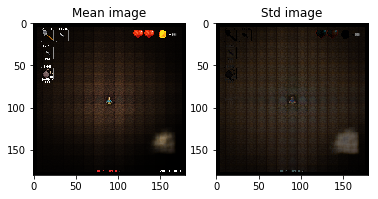

In [5]:
if usingResNet:
    meanImage = np.load("data/stats/dsetMean_ResNet.npy")
    stdImage = np.load("data/stats/dsetStd_ResNet.npy")
else:
    meanImage = np.load("data/stats/dsetMean.npy")
    stdImage = np.load("data/stats/dsetStd.npy")
plt.subplot(121)
plt.imshow(np.array(np.round(meanImage), dtype=np.uint8))
plt.title("Mean image")
plt.subplot(122)
plt.imshow(np.array(np.round(stdImage), dtype=np.uint8))
plt.title("Std image")
# get channel means formatted like tensors
channelMeans = meanImage.transpose((2,0,1)).mean(axis=(1,2)) / 255
channelStds = meanImage.transpose((2,0,1)).std(axis=(1,2)) / 255

transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(channelMeans, channelStds)
        ])

In [6]:
windowName = "Crypt of the NecroDancer"

env = GameEnv(windowName, 0.32, usingResNet)
agent = CloningAgent(model, transform, gamma=0.99)

using cuda


# Train the model using policy gradients

In [7]:
running_reward = 20
log_interval = 10
rewardsOverTime = []

In [8]:
print("Move the windows taskbar!")
time.sleep(4) # activate the game window during this
for i_episode in range(800):
    state = env.reset()
    t, timeSinceReward, totalReward = 0, 0, 0
    while timeSinceReward < 50:  # Don't infinite loop while learning
        action = agent.sampleAction(state, verbose=(t%100==0))
        state, reward, done = env.step(action)
        if reward != 0:
            timeSinceReward = 0
            totalReward += reward
#             print("Got reward {}.".format(reward))
        agent.rewards.append(reward)
        aborted = win32gui.GetWindowText(win32gui.GetForegroundWindow()) != windowName
        if aborted or done:
            break
        timeSinceReward += 1
        t += 1
    if aborted:
        print("Game window no longer active. Stopping training.")
        break
    
    print('finishing episode...')
    running_reward = running_reward * 0.95 + totalReward * 0.05
    agent.finishEpisode()
    rewardsOverTime.append(totalReward)
    
    print('Episode {}\tLast reward: {:5d}\tAverage reward: {:.2f}'.format(
            i_episode, totalReward, running_reward))
    if i_episode % log_interval == 0:
        torch.save(agent.model.state_dict(), "models/PG_deeperquads_nopre/{}.pt".format(i_episode))
    

Move the windows taskbar!
tensor([[-0.5733, -0.0122,  0.9897, -0.2824]], device='cuda:0')
tensor([[-0.0101, -0.7052,  0.1429,  5.6299]], device='cuda:0')
finishing episode...
Episode 0	Last reward:   140	Average reward: 27.15
tensor([[-0.2286, -0.2514,  0.9339,  0.5972]], device='cuda:0')
finishing episode...
Episode 1	Last reward:     0	Average reward: 28.29
tensor([[-0.6094, -0.1083,  1.1034,  0.6917]], device='cuda:0')
tensor([[-4.9456,  4.6120, -4.3226,  3.2367]], device='cuda:0')
finishing episode...
Episode 2	Last reward:   190	Average reward: 33.28
tensor([[-0.2123, -0.3260,  0.8767,  0.2260]], device='cuda:0')
finishing episode...
Episode 3	Last reward:     0	Average reward: 34.06
tensor([[-0.7989,  0.0179,  1.1219, -0.4340]], device='cuda:0')
finishing episode...
Episode 4	Last reward:    60	Average reward: 37.06
tensor([[-0.4270, -0.0700,  0.6987, -0.3031]], device='cuda:0')
finishing episode...
Episode 5	Last reward:    30	Average reward: 39.11
tensor([[-0.2875,  0.3068,  0.

finishing episode...
Episode 52	Last reward:    30	Average reward: 70.82
tensor([[-0.2815, -0.2044,  0.6887,  0.2576]], device='cuda:0')
finishing episode...
Episode 53	Last reward:     0	Average reward: 70.28
tensor([[-0.3858, -0.0753,  0.7220, -0.2237]], device='cuda:0')
tensor([[-0.0384, -0.0901,  0.2023,  1.8813]], device='cuda:0')
finishing episode...
Episode 54	Last reward:    80	Average reward: 73.36
tensor([[-0.7472, -0.2744,  1.3325, -0.9810]], device='cuda:0')
tensor([[-0.1346,  0.1735, -1.6702,  2.4248]], device='cuda:0')
finishing episode...
Episode 55	Last reward:    30	Average reward: 75.39
tensor([[-0.4005, -0.2833,  1.0232, -0.8283]], device='cuda:0')
finishing episode...
Episode 56	Last reward:     0	Average reward: 74.12
tensor([[-0.5566,  0.1909,  0.6193, -0.4600]], device='cuda:0')
finishing episode...
Episode 57	Last reward:    40	Average reward: 75.32
tensor([[-0.5624, -0.1231,  0.9547, -1.5678]], device='cuda:0')
tensor([[ 1.3410,  0.9044, -3.0910, -1.6881]], dev

tensor([[-0.4346, -0.3415,  1.1535, -0.0405]], device='cuda:0')
finishing episode...
Episode 103	Last reward:   -40	Average reward: 78.09
tensor([[-0.5240, -0.2518,  1.1970, -0.2759]], device='cuda:0')
finishing episode...
Episode 104	Last reward:   -10	Average reward: 75.44
tensor([[-0.6680, -0.1607,  1.2608, -1.1774]], device='cuda:0')
finishing episode...
Episode 105	Last reward:   230	Average reward: 76.22
tensor([[-0.3894, -0.3257,  1.1693, -0.3004]], device='cuda:0')
finishing episode...
Episode 106	Last reward:    40	Average reward: 76.10
tensor([[-0.3446, -0.1911,  0.8235,  0.9035]], device='cuda:0')
finishing episode...
Episode 107	Last reward:    30	Average reward: 76.25
tensor([[-0.1896, -0.3606,  0.9816, -0.0343]], device='cuda:0')
finishing episode...
Episode 108	Last reward:    10	Average reward: 76.24
tensor([[-0.3665, -0.2101,  0.8460,  0.1619]], device='cuda:0')
finishing episode...
Episode 109	Last reward:   -40	Average reward: 72.98
tensor([[-0.6595, -0.0538,  0.9579

finishing episode...
Episode 155	Last reward:    80	Average reward: 88.15
tensor([[-1.2528,  0.7126,  0.9005, -1.7263]], device='cuda:0')
tensor([[-6.3562,  5.4834, -6.3593,  2.6463]], device='cuda:0')
finishing episode...
Episode 156	Last reward:   100	Average reward: 90.60
tensor([[-0.6286, -0.3327,  1.4560, -1.7569]], device='cuda:0')
finishing episode...
Episode 157	Last reward:    20	Average reward: 90.12
tensor([[-0.4349,  0.0875,  0.5688, -0.2140]], device='cuda:0')
finishing episode...
Episode 158	Last reward:    50	Average reward: 89.96
tensor([[-0.5853, -0.2149,  1.2077,  0.2032]], device='cuda:0')
tensor([[ 2.8070, -2.9052,  2.7468, -1.0197]], device='cuda:0')
finishing episode...
Episode 159	Last reward:    50	Average reward: 90.51
tensor([[-0.2753, -0.6221,  1.3796, -0.6668]], device='cuda:0')
finishing episode...
Episode 160	Last reward:    20	Average reward: 88.94
tensor([[-0.3939, -0.1584,  0.8306,  0.2818]], device='cuda:0')
tensor([[-1.8858,  2.2502, -1.5681, -0.6619]

finishing episode...
Episode 210	Last reward:    20	Average reward: 70.41
tensor([[ 0.2472, -0.0432, -0.1376,  0.1632]], device='cuda:0')
tensor([[-2.5355,  1.6216, -0.0224, -3.0219]], device='cuda:0')
finishing episode...
Episode 211	Last reward:    80	Average reward: 74.74
tensor([[-0.3531,  0.0061,  0.6841, -0.5635]], device='cuda:0')
tensor([[-2.1107,  1.2896, -1.5350,  2.8649]], device='cuda:0')
finishing episode...
Episode 212	Last reward:    30	Average reward: 76.20
tensor([[-0.2066, -0.5592,  0.9281,  1.4640]], device='cuda:0')
finishing episode...
Episode 213	Last reward:   -40	Average reward: 73.14
tensor([[-0.4331,  0.1090,  0.4937,  0.1606]], device='cuda:0')
finishing episode...
Episode 214	Last reward:    50	Average reward: 74.13
tensor([[ 0.4720, -1.3203,  1.8621,  0.8035]], device='cuda:0')
tensor([[-5.9484,  5.7749, -7.1229,  3.4402]], device='cuda:0')
tensor([[ 1.4113, -0.2581, -2.4774, -1.0465]], device='cuda:0')
finishing episode...
Episode 215	Last reward:   160	Av

finishing episode...
Episode 262	Last reward:   -30	Average reward: 81.24
tensor([[-0.4134,  0.1386,  0.5747, -0.1632]], device='cuda:0')
finishing episode...
Episode 263	Last reward:   -10	Average reward: 80.43
tensor([[-0.4083, -0.3406,  0.9946, -0.5070]], device='cuda:0')
finishing episode...
Episode 264	Last reward:    20	Average reward: 80.96
tensor([[-0.5090, -0.5004,  1.4934, -0.7349]], device='cuda:0')
tensor([[ 6.1407, -1.5260, -7.1544, -4.7721]], device='cuda:0')
finishing episode...
Episode 265	Last reward:    90	Average reward: 82.81
tensor([[-0.4718, -0.6015,  1.6104, -1.7051]], device='cuda:0')
finishing episode...
Episode 266	Last reward:    30	Average reward: 83.07
tensor([[-0.4088, -0.5497,  1.4448, -0.8071]], device='cuda:0')
tensor([[-1.9868,  1.5130, -1.3606,  2.9677]], device='cuda:0')
finishing episode...
Episode 267	Last reward:    70	Average reward: 85.82
tensor([[-0.4441, -0.2603,  1.0292, -1.1810]], device='cuda:0')
tensor([[  0.8335,  -5.9090,  12.4645,  -4.3

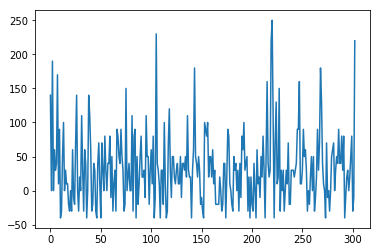

In [13]:
plt.plot(rewardsOverTime)
# plt.axis([0, 135, -40, 200])
plt.show()

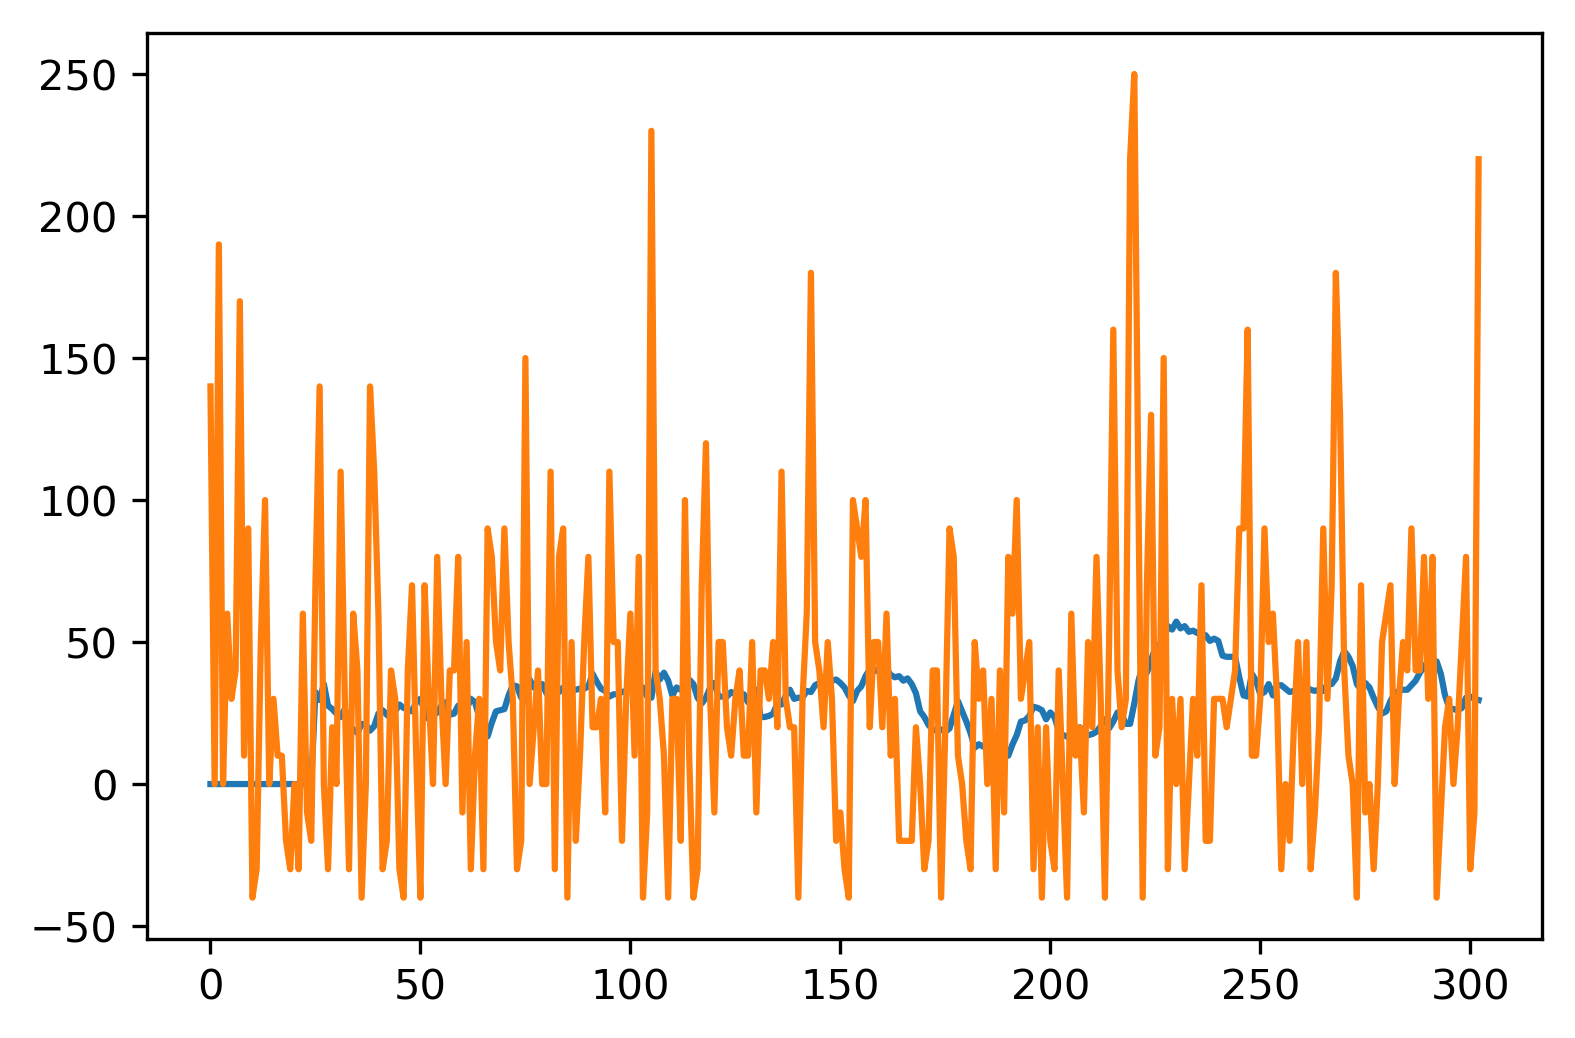

In [16]:
avgs = []
N = 25
for i in range(N):
    avgs.append(0)
for i in range(N, len(rewardsOverTime)):
    avgs.append(sum(rewardsOverTime[i-N:i])/N)
plt.figure(dpi=300)
plt.plot(avgs)
plt.plot(rewardsOverTime)
# plt.axis([0, 120, -40, 200])
plt.savefig('demos/deeperquads_nopre.png')
plt.show()


# Run the model greedily after training

In [21]:
print("Move the windows taskbar!")
with torch.no_grad():
    time.sleep(4) # activate the game window during this
    state = env.reset()
    while win32gui.GetWindowText(win32gui.GetForegroundWindow()) == windowName: # exit on window unfocus
        actionScores = agent.getActionScores(state)
#         print(actionScores)
        action = np.argmax(actionScores.data.cpu().numpy()[0])
        state, reward, done = env.step(action)
#         time.sleep(0.4)
        if reward != 0:
            print("Got reward {}.".format(reward))
        
print("Game window no longer active. Exiting.")

Move the windows taskbar!
Got reward 10.
Got reward 10.
Got reward -20.
Got reward 10.
Got reward 10.
Got reward 10.
Got reward 10.
Got reward 10.
Got reward 10.
Got reward 10.
Got reward 10.
Got reward -10.
Got reward -10.
Got reward 10.
Game window no longer active. Exiting.
